<a href="https://colab.research.google.com/github/andrewkoji/Final_Phase_Project_Text_Summarizer/blob/main/Seq2Seq_Model_Attn_Layer_text_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_preprocessing


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention
import warnings
pd.set_option("display.max_colwidth", 200)

warnings.filterwarnings("ignore")

# Preview of Dataframe

In [4]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cnn_data/test.csv")

df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putti...",Experts question if packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room th...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,"A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India. Rahul Kumar, 17, clambered over the enclosure fence at the Kamla Nehru Zoological...","Drunk teenage boy climbed into lion enclosure at zoo in west India .\nRahul Kumar, 17, ran towards animals shouting 'Today I kill a lion!'\nFortunately he fell into a moat before reaching lions an..."
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a new two-year deal to remain at Nottingham Forest. Freedman has stabilised Forest since he replaced cult hero Stuart Pearce and the club's owners are p...,Nottingham Forest are close to extending Dougie Freedman's contract .\nThe Forest boss took over from former manager Stuart Pearce in February .\nFreedman has since lead the club to ninth in the C...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,"Liverpool target Neto is also wanted by PSG and clubs in Spain as Brendan Rodgers faces stiff competition to land the Fiorentina goalkeeper, according to the Brazilian's agent Stefano Castagna. Th...","Fiorentina goalkeeper Neto has been linked with Liverpool and Arsenal .\nNeto joined Firoentina from Brazilian outfit Atletico Paranaense in 2011 .\nHe is also wanted by PSG and Spanish clubs, acc..."
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,"Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month. The former Olympian and reality TV star, 65, will speak in a 'far-ranging' interview with Sawyer for...","Tell-all interview with the reality TV star, 69, will air on Friday April 24 .\nIt comes amid continuing speculation about his transition to a woman and following his involvement in a deadly car c..."


In [5]:
cd drive/My Drive/Colab Notebooks


/content/drive/My Drive/Colab Notebooks


In [6]:
from attention import AttentionLayer

In [7]:
# @title Sample Article


In [8]:
df['article'][1000]

"Cristiano Ronaldo and Lionel Messi will go head-to-head once more in the race to be this season's top scorer in the Champions League – although Luiz Adriano threatens to spoil the party. Both Barcelona and Real Madrid booked their spots in the semi-finals this week with victories over Paris Saint-Germain and Atletico Madrid respectively. The planet's best footballers have scored eight times in Europe this season. But Shakhtar Donetsk’s Adriano, courted by Arsenal and Liverpool, has netted on nine occasions this term. Cristiano Ronaldo, in action against Atletico Madrid on Wednesday evening, has scored eight goals in Europe . Lionel Messi also has eight goals in the Champions League this term; one fewer than Luiz Adriano . Ronaldo and Messi will both play at least two more times after Real Madrid and Barcelona reached the last four . Adriano, who moved to Donetsk in 2007, scored five against BATE Borsiov in the group stages. His performance that night made history, with the 27-year-old

In [9]:
df['highlights'][1000]

"Luiz Adriano scored nine times for Shakhtar Donetsk in Europe this season .\nThe Brazilian is out of contract at the end of the year... both Arsenal and Liverpool are interested in signing the 27-year-old .\nCristiano Ronaldo and Lionel Messi have netted eight goals this season .\nReal Madrid and Barcelona both in the Champions League semi-finals .\nREAD: Our reporters have their say on who will win the Champions League .\nCLICK HERE for Sportsmail's guide to the Champions League final four ."

In [10]:
# @title Checking for length and nulls


In [11]:
len(df)

11490

In [12]:
df.isnull().sum()

id            0
article       0
highlights    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11490 non-null  object
 1   article     11490 non-null  object
 2   highlights  11490 non-null  object
dtypes: object(3)
memory usage: 269.4+ KB


# Getting the word count
## The purpose of the code below is to provide a quantitative measure of the word count for each article in the DataFrame. Knowing the word count of each article can be valuable for various natural language processing tasks, such as text summarization, where you might want to generate a concise summary of the content while preserving essential information or meeting a specific length requirement. By having the word count readily available in the 'WordCount' column, you can make informed decisions and apply algorithms or methods that take the length of the text into account during the summarization process, ensuring that the generated summaries are of an appropriate length.

### After we generate the word count we will:

- Look at distribution
- Look at general statistics like the mean and median to analyze the general text length

In [14]:
from pandas.core.groupby.generic import DataFrameGroupBy
# Function to count words in a text column
def count_words(text):
    words = text.split()
    return len(words)

# Apply the function to the DataFrame column
df['articleWordCount'] = df['article'].apply(count_words)
df['highlightsWordCount'] = df['highlights'].apply(count_words)
df.head()

,id,article,highlights,articleWordCount,highlightsWordCount
0,92c514c913c0bdfe25341af9fd72b29db544099b,"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putti...",Experts question if packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room th...,370,36
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,"A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India. Rahul Kumar, 17, clambered over the enclosure fence at the Kamla Nehru Zoological...","Drunk teenage boy climbed into lion enclosure at zoo in west India .\nRahul Kumar, 17, ran towards animals shouting 'Today I kill a lion!'\nFortunately he fell into a moat before reaching lions an...",311,38
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a new two-year deal to remain at Nottingham Forest. Freedman has stabilised Forest since he replaced cult hero Stuart Pearce and the club's owners are p...,Nottingham Forest are close to extending Dougie Freedman's contract .\nThe Forest boss took over from former manager Stuart Pearce in February .\nFreedman has since lead the club to ninth in the C...,110,35
3,caabf9cbdf96eb1410295a673e953d304391bfbb,"Liverpool target Neto is also wanted by PSG and clubs in Spain as Brendan Rodgers faces stiff competition to land the Fiorentina goalkeeper, according to the Brazilian's agent Stefano Castagna. Th...","Fiorentina goalkeeper Neto has been linked with Liverpool and Arsenal .\nNeto joined Firoentina from Brazilian outfit Atletico Paranaense in 2011 .\nHe is also wanted by PSG and Spanish clubs, acc...",308,44
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,"Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month. The former Olympian and reality TV star, 65, will speak in a 'far-ranging' interview with Sawyer for...","Tell-all interview with the reality TV star, 69, will air on Friday April 24 .\nIt comes amid continuing speculation about his transition to a woman and following his involvement in a deadly car c...",749,61


# Contraction Mapping

In [15]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [16]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
#call the function
cleaned_text = []
for t in df['article']:
    cleaned_text.append(text_cleaner(t,0))

In [18]:
#call the function
cleaned_summary = []
for t in df['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

In [19]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

# Dropping Empty Rows

In [20]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

# Analyzing the length of the highlights
## The purpose the code below is to analyze and gain insights into the distribution of summary lengths within a dataset. By iterating through the 'cleaned_summary' column of the DataFrame and checking the number of words in each cleaned summary, the code helps identify how many of these summaries are concise, containing 75 words or less. This analysis is valuable in various natural language processing and text analysis tasks, such as text summarization or information retrieval, as it provides an understanding of the dataset's summarization patterns. Furthermore, it allows data practitioners to assess the suitability of the dataset for specific applications that may have constraints on summary length.





In [61]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=75):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9079199303742385


## We observe that 91% of the highlights have length below 75. So, we can fix maximum length of summary to 75.

Let us fix the maximum length of an article to 750

In [62]:
cnt=0
for i in df['cleaned_text']:
    if(len(i.split())<=750):
        cnt=cnt+1
print(cnt/len(df['cleaned_text']))

0.9483899042645779


## We observe that 95% of the articles have length below 750. So, we can fix maximum length of summary to 750.

In [64]:
max_text_len=750
max_summary_len=75

## The purpose of the code below is to filter and create a new dataset (data) that contains text and summary pairs where both the text and summary have lengths within certain limits (max_summary_len and max_text_len). This can be useful when working with text summarization tasks or other natural language processing applications where controlling the length of input and output sequences is important. The resulting data DataFrame can be used for training, validation, or testing in machine learning models or other text analysis tasks.

In [24]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

data=pd.DataFrame({'article':short_text,'highlights':short_summary})

In [25]:
df.head()

,id,article,highlights,articleWordCount,highlightsWordCount,cleaned_text,cleaned_summary
0,92c514c913c0bdfe25341af9fd72b29db544099b,"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putti...",Experts question if packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room th...,370,36,ever noticed plane seats appear getting smaller smaller increasing numbers people taking skies experts questioning packed planes putting passengers risk say shrinking space aeroplanes uncomfortabl...,experts question if packed out planes are putting passengers at risk consumer advisory group says minimum space must be stipulated safety tests conducted on planes with more leg room than airlines...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,"A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India. Rahul Kumar, 17, clambered over the enclosure fence at the Kamla Nehru Zoological...","Drunk teenage boy climbed into lion enclosure at zoo in west India .\nRahul Kumar, 17, ran towards animals shouting 'Today I kill a lion!'\nFortunately he fell into a moat before reaching lions an...",311,38,drunk teenage boy rescued security jumping lions enclosure zoo western india rahul kumar clambered enclosure fence kamla nehru zoological park ahmedabad began running towards animals shouting woul...,drunk teenage boy climbed into lion enclosure at zoo in west india rahul kumar ran towards animals shouting today kill lion fortunately he fell into moat before reaching lions and was rescued
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a new two-year deal to remain at Nottingham Forest. Freedman has stabilised Forest since he replaced cult hero Stuart Pearce and the club's owners are p...,Nottingham Forest are close to extending Dougie Freedman's contract .\nThe Forest boss took over from former manager Stuart Pearce in February .\nFreedman has since lead the club to ninth in the C...,110,35,dougie freedman verge agreeing new two year deal remain nottingham forest freedman stabilised forest since replaced cult hero stuart pearce club owners pleased job done city ground dougie freedman...,nottingham forest are close to extending dougie freedman contract the forest boss took over from former manager stuart pearce in february freedman has since lead the club to ninth in the championship
3,caabf9cbdf96eb1410295a673e953d304391bfbb,"Liverpool target Neto is also wanted by PSG and clubs in Spain as Brendan Rodgers faces stiff competition to land the Fiorentina goalkeeper, according to the Brazilian's agent Stefano Castagna. Th...","Fiorentina goalkeeper Neto has been linked with Liverpool and Arsenal .\nNeto joined Firoentina from Brazilian outfit Atletico Paranaense in 2011 .\nHe is also wanted by PSG and Spanish clubs, acc...",308,44,liverpool target neto also wanted psg clubs spain brendan rodgers faces stiff competition land fiorentina goalkeeper according brazilian agent stefano castagna reds linked move year old whose cont...,fiorentina goalkeeper neto has been linked with liverpool and arsenal neto joined firoentina from brazilian outfit atletico paranaense in he is also wanted by psg and spanish clubs according to hi...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,"Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month. The former Olympian and reality TV star, 65, will speak in a 'far-ranging' interview with Sawyer for...","Tell-all interview with the reality TV star, 69, will air on Friday April 24 .\nIt comes amid continuing speculation about his transition to a woman and following his involvement in a deadly car c...",749,61,bruce jenner break silence two hour interview diane sawy

# Seq2Seq Prep
## Now we want to prepare the 'highlights' column of the DataFrame data for sequence-to-sequence (seq2seq) model training, specifically for text summarization tasks. This code applies a lambda function to each element in the 'highlights' column, which typically contains the summary or the target sequence.

- 'sostok ' is added to the beginning of each summary. 'sostok' is a special token that represents the start of a sequence in the context of sequence-to-sequence models. 'eostok' is added to the end of each summary. 'eostok' is a special token that represents the end of a sequence in the context of sequence-to-sequence models.

- The result of this operation is that each summary in the 'highlights' column is enclosed with 'sostok' at the beginning and 'eostok' at the end. This formatting is commonly used in seq2seq models for tasks like text summarization to indicate the start and end points of the target sequence.

- By adding these special tokens, the code prepares the 'highlights' column for training a seq2seq model to generate summaries from the input text data. These tokens help the model learn where the summary should start and end when generating output sequences during training and inference.

In [26]:
data['highlights'] = data['highlights'].apply(lambda x : 'sostok '+ x + ' eostok')

In [27]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['article']),np.array(data['highlights']),test_size=0.1,random_state=0,shuffle=True)

In [28]:
from keras.preprocessing.text import Tokenizer

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [29]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 51.30581858377615
Total Coverage of rare words: 2.009739591395932



- tot_cnt gives the size of vocabulary (which means every unique words in the text)

- cnt gives me the no. of rare words whose count falls below threshold

- tot_cnt - cnt gives me the top most common words

## Let us define the tokenizer with top most common words for reviews.

### This code prepares text data for NLP tasks by tokenizing the text, converting it into integer sequences, and ensuring that the sequences have the same length through padding. It also calculates the size of the vocabulary that will be used in subsequent NLP model training.

In [30]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [31]:
x_voc

36564

# Summary Tokenizer

In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# Rarewords and its Coverage
## Let us look at the proportion rare words and its total coverage in the entire summary

### Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word



In [33]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value


print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.96568002480963
Total Coverage of rare words: 9.554010353119558


In [34]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [35]:
y_voc

6976

Let us check whether word count of start token is equal to length of the training data

In [36]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(8974, 8974)

Here, I am deleting the rows that contain only START and END tokens

In [37]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [38]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building
## We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

- Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

- Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

- Initial State: This is used to initialize the internal states of the LSTM for the first timestep

- Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

### Here, we are building a 3 stacked LSTM for the encoder:


In [39]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 750)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 750, 100)             3656400   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 750, 300),           481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [42]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/15
71/71 [==============================] - 587s 8s/step - loss: 4.7520 - val_loss: 4.1935
Epoch 2/15
71/71 [==============================] - 565s 8s/step - loss: 3.9943 - val_loss: 3.8890
Epoch 3/15
71/71 [==============================] - 566s 8s/step - loss: 3.9243 - val_loss: 3.8616
Epoch 4/15
71/71 [==============================] - 564s 8s/step - loss: 3.9051 - val_loss: 3.8495
Epoch 5/15
71/71 [==============================] - 559s 8s/step - loss: 3.8944 - val_loss: 3.8444
Epoch 6/15
71/71 [==============================] - 559s 8s/step - loss: 3.8794 - val_loss: 3.8192
Epoch 7/15
71/71 [==============================] - 561s 8s/step - loss: 3.8604 - val_loss: 3.8103
Epoch 8/15
71/71 [==============================] - 560s 8s/step - loss: 3.8411 - val_loss: 3.7867
Epoch 9/15
71/71 [==============================] - 562s 8s/step - loss: 3.8240 - val_loss: 3.7796
Epoch 10/15
71/71 [==============================] - 561s 8s/step - loss: 3.8097 - val_loss: 3.7620
Epoch 11/

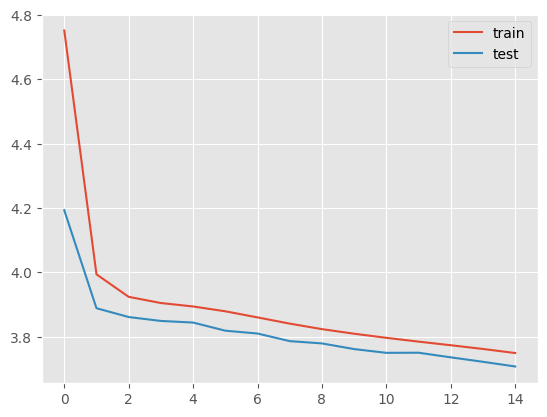

In [55]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [44]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [45]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [47]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [48]:
for i in range(0,50):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: poet sappho declared love women greek island lesbos may linked idea female homosexuality ancient times notorious sexual playground straight men found local women irresistible new bbc documentary former apprentice star margaret mountford reveal island magaluf day capital sex tourism professor hall king college london tells programme lesbos particular reputation producing beautiful women really supposed sexiest people entire greek world added ancient greek world word lesbian actually meant woman performing intimate sex act man professor hall also explained fact lesbos closer turkey athens added sexual allure women said also interesting accent would sounded almost oriental nearer asia greek accent would like mountford describes island sex tourism capital ancient aegean programme examines life legacy female poet sappho lived island around bc one great writers ancient world wrote poems appeared declarations love women result name island become synonymous although usage started th ce

In [ ]:

print("article:",seq2text(x_tr[1]))
print("Original summary:",seq2summary(y_tr[1]))

print("Predicted summary:",decode_sequence(x_tr[1].reshape(1,max_text_len)))
print("\n")

In [ ]:
print("article:",seq2text(x_tr[2]))
print("Original summary:",seq2summary(y_tr[2]))
print("Predicted summary:",decode_sequence(x_tr[2].reshape(1,max_text_len)))
print("\n")

# Model Evaluation

In [ ]:
!pip install rouge

In [ ]:
# rouge score
def get_rouge_score(summary, abstract):
    scores = rouge.get_scores(summary, abstract)
    return scores

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [54]:
for i in range(0,5):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")
    print("Rouge Score Recall:", get_rouge_score(seq2summary(y_tr[i]), decode_sequence(x_tr[i].reshape(1,max_text_len)))[0]['rouge-l'])

Review: poet sappho declared love women greek island lesbos may linked idea female homosexuality ancient times notorious sexual playground straight men found local women irresistible new bbc documentary former apprentice star margaret mountford reveal island magaluf day capital sex tourism professor hall king college london tells programme lesbos particular reputation producing beautiful women really supposed sexiest people entire greek world added ancient greek world word lesbian actually meant woman performing intimate sex act man professor hall also explained fact lesbos closer turkey athens added sexual allure women said also interesting accent would sounded almost oriental nearer asia greek accent would like mountford describes island sex tourism capital ancient aegean programme examines life legacy female poet sappho lived island around bc one great writers ancient world wrote poems appeared declarations love women result name island become synonymous although usage started th ce

In [72]:
articles = []
summaries = []
original_summaries = []
rouge_scores = []
for i in range(0,100):
    articles.append(seq2text(x_tr[i]))
    original_summaries.append(seq2summary(y_tr[i]))
    summaries.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")
    rouge_scores.append(get_rouge_score(seq2summary(y_tr[i]), decode_sequence(x_tr[i].reshape(1,max_text_len)))[0]['rouge-l']['p'])

df_rouge = pd.DataFrame()
df_rouge['articles'] = articles
df_rouge['predicted_summaries'] = summaries
df_rouge['original_summaries'] = original_summaries
df_rouge['scores'] = rouge_scores



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==========================

In [73]:
df_rouge.head(20)

,articles,predicted_summaries,original_summaries,scores
0,poet sappho declared love women greek island lesbos may linked idea female homosexuality ancient times notorious sexual playground straight men found local women irresistible new bbc documentary f...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,the greek island was the sex tourism capital of the ancient former tv star margaret will describe life on the island in new television programme show also life and legacy of the female who lived o...,0.066667
1,least migrants trying reach europe libya killed boat capsized emerged tonight also claimed body one migrant died another boat making perilous trip north africa italy tossed overboard trafficker ci...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,around migrants trying to reach europe died when their boat capsized body of one migrant on another vessel was thrown to sharks stories emerged after more than crossed mediterranean at weekend,0.000000
2,britain biggest banks earmarked billions pounds costs fines last three years britain biggest banks racked billion bill three years pay financial scandals costs wiped per cent profits according acc...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,britain banks set aside billion last year in compensation last year another billion was for fines for foreign total charge of last year was billion figures revealed,0.105263
3,danny willett gave rules official line sight verbal blast clearly audible spectators surrounding th green masters thursday englishman willett vented anger second shot beyond green trickled way acr...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,danny willett referee for getting in line of sight anger at official as he the th at masters willett carded one under on opening round in first time at augusta,0.076923
4,years ago david seaman pulled one iconic saves fa cup history sheffield united old trafford former arsenal keeper says best one ever made arsene wenger side hanging thread lower league opponents p...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,david reveals that his save against sheffield united was his best the former arsenal keeper kept out paul header has warned the gunners to be of reading arsenal were given time by sheffield united...,0.054054
5,creating romantic toned images instagram filters play back early st century taking picture entirely different process requiring patience precision talented eye snaps young woman red posing lulwort...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,photographer was when he snapped the pictures in was known as an early of colour photography and used the process his teenage daughter posed in red at dorset photography process used and to create...,0.051282
6,psychologist surrendered registration woman suffering depression claimed told nice asked massage appointment throughout consultation woman house october sydney psychologist darryl dewar hugged cli...,the year old is the in the league in the league the year old is the the the league in the league the year old is the the the league in the league,sydney has his was accused of misconduct after woman claimed mr told her she had and swore at her she also said he her head and asked her for neck tribunal found the woman evidence was,0.034483
7,two men became locked inside airtight bank vault six hours dramatically rescued firefighters using heavy drills jacob church joe tobin art e

In [74]:
df_rouge['scores'].mean()

0.06627360633516488

In [75]:

# saving the dataframe
df_rouge.to_csv('lstm_results.csv')


In [76]:
from google.colab import files
files.download('lstm_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>